주식 마감 주가 예측
- data-02-stock_daily.csv 사용
- 개장 주가 장중 최대지수/최소지수 거래량 data를 사용하여 마감 지수를 예측
- data = pd.read_csv("data-02-stock_daily.csv", header=1) #헤더 정보 입력

In [2]:
#데이터 확인
import pandas as pd
df = pd.read_csv("/data-02-stock_daily.csv", delim_whitespace=True, header=None)
#delim_whitespace=True : 스페이스로 띄워놓은거 구분자로 활용
print(df.head())

                                                   0                                                  1
0                                                  #  http://finance.yahoo.com/quote/GOOG/history?lt...
1                         Open,High,Low,Volume,Close                                                NaN
2  828.659973,833.450012,828.349976,1247700,831.6...                                                NaN
3  823.02002,828.070007,821.655029,1597800,828.07...                                                NaN
4  819.929993,824.400024,818.97998,1281700,824.15...                                                NaN


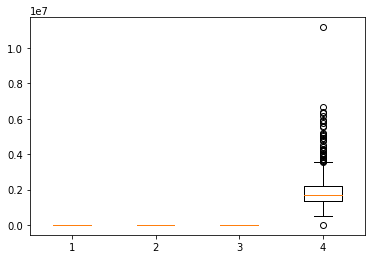

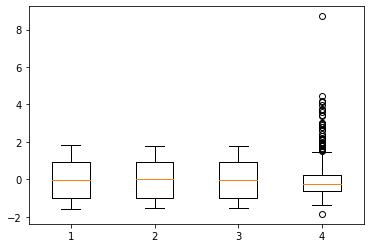

Epoch 1/5000
35/35 [==============================] - 1s 13ms/step - loss: 320448.2500 - val_loss: 36304.7812

Epoch 00001: val_loss improved from inf to 36304.78125, saving model to ./model/01-36304.7812.hdf5
Epoch 2/5000
35/35 [==============================] - 0s 8ms/step - loss: 39091.7617 - val_loss: 22965.1855

Epoch 00002: val_loss improved from 36304.78125 to 22965.18555, saving model to ./model/02-22965.1855.hdf5
Epoch 3/5000
35/35 [==============================] - 0s 8ms/step - loss: 21644.3184 - val_loss: 14248.0400

Epoch 00003: val_loss improved from 22965.18555 to 14248.04004, saving model to ./model/03-14248.0400.hdf5
Epoch 4/5000
35/35 [==============================] - 0s 8ms/step - loss: 13023.0469 - val_loss: 7799.2798

Epoch 00004: val_loss improved from 14248.04004 to 7799.27979, saving model to ./model/04-7799.2798.hdf5
Epoch 5/5000
35/35 [==============================] - 0s 8ms/step - loss: 7010.8389 - val_loss: 3663.1917

Epoch 00005: val_loss improved from 77

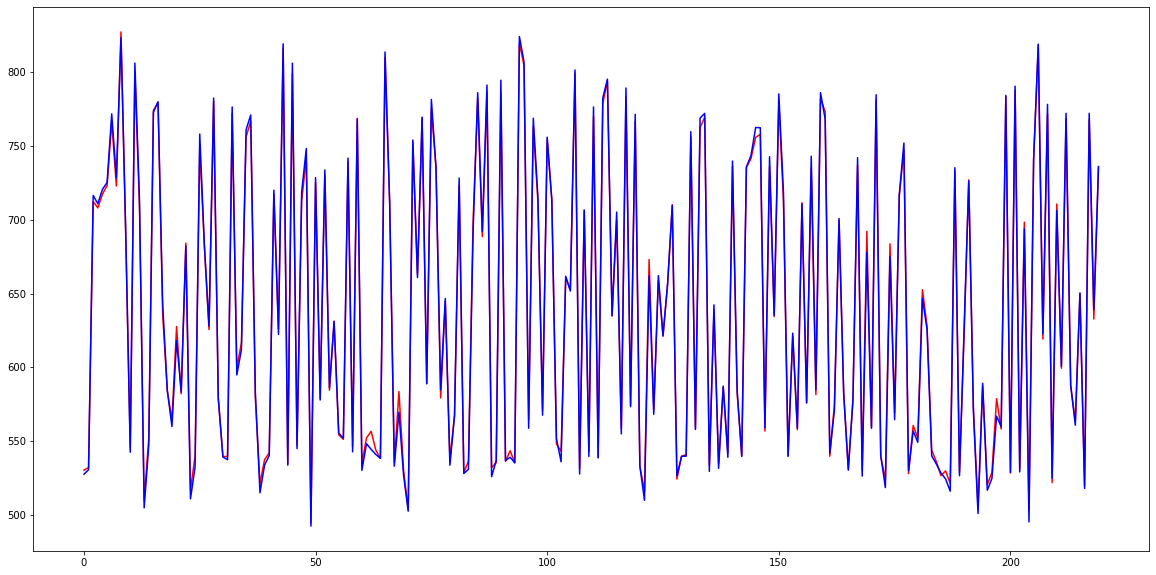

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler    #데이터 정규화

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#seed값 설정
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

#데이터 입력
df_pre = pd.read_csv("/data-02-stock_daily.csv", header=1)
df = df_pre.sample(frac=1)

#데이터 분류
dataset = df.values
X = dataset[:, 0:4]
Y = dataset[:, 4]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

#X_train만 boxplot으로 시각화 확인
plt.boxplot(X_train)
plt.show()

#데이터정규화
#X_train = StandardScaler().fit_transform(X_train)

#정규화 X
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std
X_test -= mean
X_test /= std

#X_train만 boxplot으로 정규화 이후 시각화 확인
plt.boxplot(X_train)
plt.show()

#모델 설정
model = Sequential()
model.add(Dense(1024, input_dim=4, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(1))

#모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')

#자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)

#모델 저장 조건 설정
modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

#모델 실행
history = model.fit(X_train, Y_train, validation_split=0.33, epochs=5000, batch_size=10, callbacks=[early_stopping_callback, checkpointer])

#hist = pd.DataFrame(history.history)
#print(hist.tail())

#val값에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

#원래 값에 학습셋으로 측정한 정확도의 값을 저장
y_loss = history.history['loss']
    
#정규화 Y
#mean = Y_prediction.mean(axis=0)
#Y_prediction -= mean
#std = Y_prediction.std(axis=0)
#Y_prediction /= std
#Y_test -= mean
#Y_test /= std
    
Y_prediction = model.predict(X_test).flatten()
    
#예측 값과 실제값 그래프로 비교
plt.figure(figsize=(20,10))
plt.plot(Y_prediction, c='red')
plt.plot(Y_test, c="blue")

#예측값과 실제값 오차 평균을 측정
avr = abs(Y_prediction - Y_test).mean()
print(avr)

# 예제) 자동차 연비 예측

In [5]:
#Auto MPG 데이터셋을 사용(keras.utils.get_file 사용)
from tensorflow import keras
dataset_path = keras.utils.get_file("auto-mpg.data",
                                   "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               'Acceleration', 'Model Year', 'Origin']    #MPG가 연비
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment="\t",
                         sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
print(dataset.tail())
#1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듦
#이 기간에 출시된 자동차 정보를 모델에서 제공(실린더 수, 배기량, 마력, 공차중량 같은  
#속성이 포함, 이중 origin(원산지) 속성은 1/USA, 2/Europe, 3/Japen)
#loss = 'mse'
#optimizer = tf.keras.optimizers.RMSprop(0.001)

40960/30286 [========================================] - 0s 2us/step
      MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
393  27.0          4         140.0  ...          15.6          82       1
394  44.0          4          97.0  ...          24.6          82       2
395  32.0          4         135.0  ...          11.6          82       1
396  28.0          4         120.0  ...          18.6          82       1
397  31.0          4         119.0  ...          19.4          82       1

[5 rows x 8 columns]


In [6]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#데이터셋은 UCI 머신 러닝 저장소에서 다운로드
dataset_path = keras.utils.get_file("auto-mpg.data",
                                   "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)

#미국에서 연비가 1mpg라면 1갤런의 연료로 1마일을 갈 수 있다는 뜻
#연비가 맨 앞에 표시됨
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               'Acceleration', 'Model Year', 'Origin']    #MPG가 연비
#na_values데이터셋 파일에 다양한 모양, 기호의 결측값이 존재, 결측값 기호를 표기해 주어
#이들 특정 기호를 pandas가 결측값으로 인식할 수 있도록 해줌. 예를 들어 문서의 숫자형 변수에
#결측값이 '?'라는 표시로 되어있다면, 이를 pandas DataFrame으로 불러읽어들였을 경우 float나
#int로 인식되어 불러오는 것이 아니라 string으로 인식해서 '?'를 결측값이 아니라 문자형으로 불러옴
#comment : 주석으로 분류되어 파싱하지 않을 문자 혹은 문자열
#skipinitialspace : True일때, delimiter 바로 뒤에 오는 공백은 무시. 기본값은 False
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment="\t",
                         sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
print(dataset.tail())

/root/.keras/datasets/auto-mpg.data
      MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
393  27.0          4         140.0  ...          15.6          82       1
394  44.0          4          97.0  ...          24.6          82       2
395  32.0          4         135.0  ...          11.6          82       1
396  28.0          4         120.0  ...          18.6          82       1
397  31.0          4         119.0  ...          19.4          82       1

[5 rows x 8 columns]


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


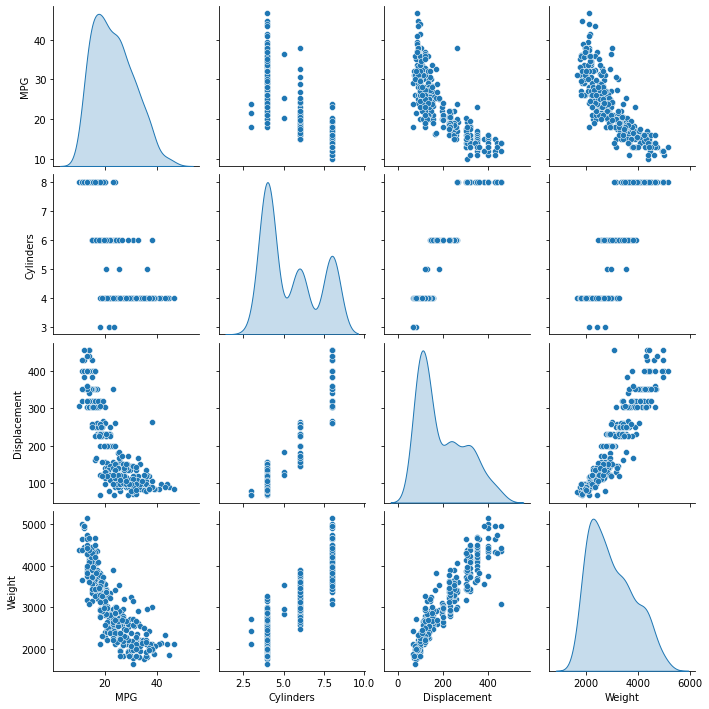

In [7]:
#DataFrame을 가지고 분석을 진행하다 보면 대부분의 경우 결측값의 문제임.
#데이터가 원래 수집 혹은 측정이 안되었을 수도 있고, 다수의 DataFrame을 서로 병합하는
#과정에서 결측값이 생길 수도 있으며, index를 재설정하는 경우에도 결측값이 발생.
#이처럼 다양한 이유로 인해서 생기는 결측값은 분석 오류가 발생시키거나 혹은 왜곡시킬 위험이
#있으므로 분석할 DataFrame을 생성했으면 결측값이 있는지 여부에 대해서 꼭
#확인하고 조치하여야 함

#칼럼별 결측값 개수 구하기 : df.isnull().sum()    (isnull()과 isna() 동일 의미 사용)
print(dataset.isnull().sum())
#문제를 간단하게 만들기 위해서 누락된 행을 삭제
dataset = dataset.dropna()

#항목중 Origin이 원산지인데 수치형이 아니고 범주형이므로 원한인코딩으로 변환
#1,2,3을 1.0 0.0 0.0 / 0.0 1.0 0.0 / 0.0 0.0 1.0 형태로 변환
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japen'] = (origin == 3) * 1.0
dataset.tail()

#학습셋 검증셋 분리
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#data확인(훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 작성)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")